# Introduction to multivariable Green's functions

In this notebook, we learn how to create and manipulate multivariable Green's functions.
As an example, we consider the Green's function on a square lattice with nearest-neighbour hopping $t$,

\begin{equation}
G(\mathbf{k},i\omega_n)=\frac{1}{i\omega_n  + \mu - \epsilon(\mathbf{k})}
\end{equation}

with dispersion $\epsilon(\mathbf{k})=-2t(\cos{k_x}+\cos{k_y})$. Here $\mathbf{k}$ is a vector in the Brillouin zone (in units where the lattice spacing is unity $a=1$), $\mu$ is the chemical potential and $i\omega_n$ is a Matsubara frequency.

## Imports and parameters

Below we import modules that will be useful in the following. We also set the
parameters of the problem.

In [1]:
# Relevant Imports 
from triqs.lattice import BravaisLattice, BrillouinZone
from triqs.gf import Gf, MeshProduct, MeshBrZone, MeshImFreq
import numpy as np
from math import cos, pi

In [2]:
# Physical parameters
beta = 2     # Inverse temperature
t = 1.0      # Hopping (unit of energy)
mu = 0       # Chemical potential

## Constructing and Initializing a Lattice Green's function

We first define a simple Bravais lattice (`BravaisLattice`) in 2 dimensions with basis vectors $\hat{e}_x = (1, 0, 0)$ and ${\hat e}_y=(0, 1, 0)$. Given this bravais lattice we construct the reciprocal (momentum) space Brillouin zone (`BrillouinZone`), on which we can then construct a momentum mesh (`MeshBrZone`).

In [3]:
BL = BravaisLattice([(1,0,0), (0,1,0)]) # Two unit vectors in R3
BZ = BrillouinZone(BL) 

# n_k denotes the number of k-points for each dimension
n_k = 128
k_mesh = MeshBrZone(bz=BZ, n_k=n_k)

The Lattice Green's function is defined on a mesh that is the cartesian product of this momentum mesh and a Matsubara mesh.

$$
G: (\mathbf{k}, i\omega_n) \rightarrow {\mathcal{C}}
$$

To construct this mesh we use the `MeshProduct` provided by TRIQS:

In [4]:
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=128)
k_iw_mesh = MeshProduct(k_mesh, iw_mesh)

# Recall that for an empty target_shape G0 has values that are scalars instead of matrices.
G = Gf(mesh=k_iw_mesh, target_shape=[])

To fill the Green's function we construct a function for the dispersion $\epsilon(\mathbf{k})$ and set each element of $G$ by looping over the momentum and frequency meshes.

In [5]:
#%%timeit
def eps(k):
    return -2*t * (cos(k[0]) + cos(k[1]))

# Loop initialization. Slow..
for k, iw in G.mesh:
    G[k, iw] = 1/(iw + mu - eps(k))

## Numpy Broadcasting

Instead of writing a loop we can use the [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) features of the numpy package to assign directly into the data-array of the Green's function object. This approach is a lot faster than writing a loop

In [6]:
iw_arr = np.array(list(iw_mesh.values()))
k_arr  = np.array(list(k_mesh.values()))
np_eps = np.vectorize(eps, signature='(d)->()')

In [7]:
#%%timeit
# Vectorized function evaluation
eps_arr = np_eps(k_arr)

# Numpy Broadcasting
G.data[:] = 1.0 / (iw_arr[None,::] + mu - eps_arr[::,None])

We provide through the [TRIQS/tprf](https://triqs.github.io/tprf) application more efficient parallelized routines for initializing lattice Green functions. Those will be introduced in the **Two Particle Reponse** Notebooks.

## Evaluate the Green function

The Green's function object $G(k,i\omega_n)$ can be evaluated like an ordinary Python function
at a given reciprocal vector and Matsubara frequency:

- The reciprocal vector $k$ is a tuple/list/numpy.array of double 
- The Matsubara frequency is an integer $n$, the $n$ in $i\omega_n$

The result will be a linear interpolation on the Brillouin zone 
  with the points on the grid of $G$ around $k$.

Therefore, one can use $g_0$ as any python function of $k$ and $i\omega_n$, 
and forget its precise representation in memory (what is the grid, etc...).
We will use that in the plot functions below.

Example:
Let's evaluate the above Green's function at $\mathbf{k} = (\pi,\pi,0)$ and $i\omega_2$. As $\epsilon((\pi,\pi,0)) = 2t = 2$ and $i\omega_2 = i\frac{(2*2 + 1)\pi}{\beta}$, we check:

In [8]:
G_eval  = G((pi,pi,0), 2)
G_exact = 1.0/(1j * (2*2+1)*pi/beta - 4)
print(G_eval - G_exact) # Check

0j


## Partial evaluation

Given a function $G(k,i\omega_n)$ it is possible to obtain the function $i\omega_n \rightarrow G(k_0, i\omega_n)$ for a fixed $k_0$:

In [9]:
k0 = (0.02,0.01,0)      # a k-point as a tuple of 3 floats
Giw = G(k0, all)        # We use the "built-in" function all here as equivalent of :, 
                        # which Python does not allow in ()
    
# Giw is a Green's function of the Matsubara frequency only
# It is calculated by k-interpolation of G
print(Giw)

# Giw uses the original Matsubara mesh
assert Giw.mesh == G.mesh[1]

Greens Function  with mesh Imaginary Freq Mesh with beta = 2, statistic = Fermion, n_iw = 128, positive_only = false and target_shape (): 



Here `Giw` is obtained through linearly of `G` for the point $k_0$ on the original Brillouin zone grid.

It is simply a Matsubara Green's function, which means that you can use all the common methods, such as `density()` or Fourier transforms:

In [10]:
# This is the density n_k at k=(0.02, 0.01)
print("n_k =",  Giw.density().real)

n_k = 0.9996637574643963


## Defining a Tight-Binding Hamiltonian

In practice we often know the tight-binding Hamiltonian on our Bravais lattice rather than the analytic dispersion relation.
TRIQS provides the `TightBinding` class for this case:

In [1]:
from triqs.lattice import TightBinding
?TightBinding

Init signature: TightBinding(self, /, *args, **kwargs)
Docstring:     
A tight-binding Hamiltonian on a Bravais lattice.

Requires the displacements in units of the lattice basis vectors (units)
and the associated overlap (hopping) matrices.
The matrix structure is w.r.t. the atoms in the unit cell.

Parameters
----------
bl : BravaisLattice
    Underlying bravais lattice
hoppings : dict(vector->matrix)
    The mapping between displacement vectors and overlap (hopping) matrices
File:           ~/opt/triqs/lib/python3.11/site-packages/triqs/lattice/lattice_tools.cpython-311-darwin.so
Type:           type
Subclasses:     

In [12]:
# Define mapping between displacement vectors and hopping amplitudes
# Matrix structure of the amplitudes is w.r.t. atoms in the unit cell (here only one).
hop= {  (1,0)  :  [[ -t]],       
        (-1,0) :  [[ -t]],     
        (0,1)  :  [[ -t]],
        (0,-1) :  [[ -t]]
     }
TB = TightBinding(bl=BL, hoppings=hop)

# Green's function on the k_mesh holding the dispersion values
eps_k = TB.dispersion(k_mesh)[0]

# Initialize the lattice Green's function using Numpy Broadcasting
Gtb = G.copy()
Gtb.data[:] = 1.0 / (iw_arr[None,::] + mu - eps_k.data[::,None])

# Check Equality
assert np.linalg.norm((G - Gtb).data) < 1e-12

Let us finally plot the dispersion relation we have obtained

Text(0.5, 0.92, '$\\epsilon(\\mathbf{k})$')

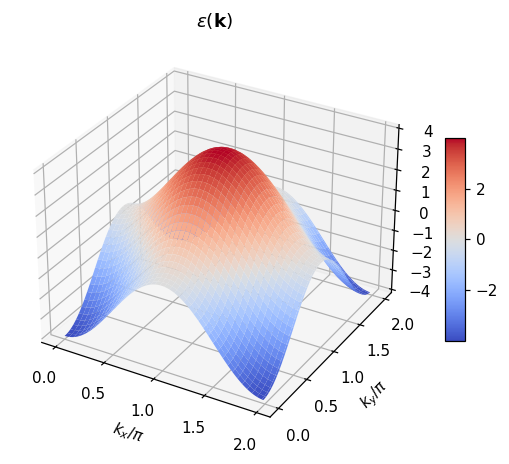

In [13]:
# Prepare the data
k_grid = k_arr.reshape(n_k,n_k,3)
X = k_grid[...,0]/pi
Y = k_grid[...,1]/pi
Z = eps_k.data.reshape(n_k,n_k)

# Plot the dispersion
from matplotlib import pyplot as plt
%matplotlib inline

fig  = plt.figure(dpi=110)
ax   = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_xlabel(r"$k_x/\pi$")
ax.set_ylabel(r"$k_y/\pi$")
ax.set_title(r"$\epsilon(\mathbf{k})$")